In [7]:
import matplotlib.font_manager as fm

# fm.fontManager.addfont("./th_sarabun.ttf")

In [8]:
# fm.fontManager.ttflist

# Introduction

- Input ...
- Visualization

- get relevance scores
  - sensitivyt analysis
  - LRP Implementation

In [9]:
import sys
print(sys.path)
import sys
sys.path.append("../") 

['/Users/pat/projects/attacut/notebooks', '/usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '', '/Users/pat/projects/attacut/venv/lib/python3.7/site-packages', '/Users/pat/projects/attacut/venv/lib/python3.7/site-packages/IPython/extensions', '/Users/pat/.ipython', '../']


In [10]:
!pip install pytorch-crf

You should consider upgrading via the '/Users/pat/projects/attacut/venv/bin/python -m pip install --upgrade pip' command.


In [5]:
from attacut import Tokenizer, char_type

In [13]:
import numpy as np
import torch
import torch.nn.functional as F
from attacut import Tokenizer
from matplotlib import pyplot as plt


sc_cnn = "../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-05-15--22-41.30/run-13"
sc_lstm = "../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-05-22--22-42.30/run-19"
atta_sc_cnn = Tokenizer(model=sc_cnn)
atta_sc_lstm = Tokenizer(model=sc_lstm)

using bi-direction


In [14]:
sentence = "อำนาจตุลาการ คือจุดอ่อนของประชาธิปไตยไทย"

sentences = [
  sentence,
  "ความแตกต่างอีกประการหนึ่งระหว่างไทยและอินเดีย",
  "เริ่ม~มี~ผู้~โทร~ศัพท์~ขอ~รับ~คำ~ปรึก~ษา~เนื่อง~จาก~เครียด".replace("~", ""),
  "แผน~ผัง~การ~ขยาย~พันธุ์~พืช~โดย~ย่อ~ๆ".replace("~", "")
]

In [15]:
atta_sc_cnn.tokenize(sentence)

['อำนาจ', 'ตุลาการ', ' ', 'คือ', 'จุดอ่อน', 'ของ', 'ประชาธิปไตย', 'ไทย']

In [16]:
atta_sc_lstm.tokenize(sentence)

['อำนาจ', 'ตุลาการ', ' ', 'คือ', 'จุดอ่อน', 'ของ', 'ประชาธิปไตย', 'ไทย']

In [17]:
def word_boundary(model, sentence):
  words = model.tokenize(sentence)
  mask = np.zeros(len(sentence))

  cur_len = 0
  for w in words:
    mask[cur_len] = 1
    cur_len += len(w)
  return mask

word_boundary(atta_sc_cnn, sentence)

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0.])

In [18]:
from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [19]:
class AttaCutSCWrapper(torch.nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.base = tokenizer

    def forward(self, x):
        embedding = x

        embedding = embedding.permute(0, 2, 1)

        conv1 = self.base.model.conv1(embedding)
        conv2 = self.base.model.conv2(conv1)
        out = self.base.model.conv3(conv2)

        out = out.permute(0, 2, 1)
        out = F.relu(self.base.model.linear1(out))
        out = self.base.model.linear2(out)

        return out

In [223]:
def interpret_atta_sc(txt, wrapper_func):
    wrapper = wrapper_func()

    def ig_attac_forward(src, idx, pred):
        return torch.softmax(wrapper.forward(src), dim=2)[:, idx, pred]

    ig_c = IntegratedGradients(ig_attac_forward)

    tokens, features = wrapper.base.dataset.make_feature(txt)
    inputs = (features, torch.Tensor(0))

    x, _, _ = wrapper.base.dataset.prepare_model_inputs(inputs, device="cpu")

    wrapper.eval()
    wrapper.zero_grad()
    
    # pre-computing word embeddings
    interpretable_ch_embedding = configure_interpretable_embedding_layer(wrapper.base.model, 'ch_embeddings')
    src_ch_indices = torch.LongTensor(x[0][:, 0, :])
    src_ch_embedding = interpretable_ch_embedding.indices_to_embeddings(src_ch_indices)
    
    
    interpretable_ch_type_embedding = configure_interpretable_embedding_layer(wrapper.base.model, 'ch_type_embeddings')
    src_ch_t_indices = torch.LongTensor(x[0][:, 1, :])
    src_ch_t_embedding = interpretable_ch_type_embedding.indices_to_embeddings(src_ch_t_indices)
    
    
    interpretable_sy_embedding = configure_interpretable_embedding_layer(wrapper.base.model, 'sy_embeddings')
    src_sy_indices = torch.LongTensor(x[0][:, 2, :])
    src_sy_embedding = interpretable_sy_embedding.indices_to_embeddings(src_sy_indices)
    
    base_ch = interpretable_ch_embedding.indices_to_embeddings(
        torch.tensor(wrapper.base.dataset.ch_dict["<PAD>"])
    )
    
    base_ch_ty = interpretable_ch_type_embedding.indices_to_embeddings(
        torch.tensor(wrapper.base.dataset.ch_dict["<PAD>"])
    )
    
    base_sy = interpretable_sy_embedding.indices_to_embeddings(
        torch.tensor(wrapper.base.dataset.sy_dict["<PAD>"])
    )
    
    
    ch_dims = src_ch_embedding.shape[2] + src_ch_t_embedding.shape[2]

    embedding = torch.cat([src_ch_embedding, src_ch_t_embedding, src_sy_embedding], dim=2)
    dd = torch.cat([base_ch, base_ch_ty, base_sy]).repeat(1, len(tokens), 1)

    f_ref = torch.softmax(wrapper(dd), dim=2)
    
    outputs = wrapper(embedding).squeeze(0)

    attribution_igs = np.zeros((len(tokens), len(tokens), 2))

    for idx in range(len(tokens)):
        pred = np.argmax(outputs[idx, :].detach().numpy())
        f = torch.softmax(outputs[idx, :], dim=0)[pred].detach().numpy()

        attribution_ig =  ig_c.attribute(
            embedding, additional_forward_args=(idx, pred),
            n_steps=100,
            baselines=dd
        ).detach().numpy()

        attribution_ig = attribution_ig.squeeze()
        total_attribution = np.sum(attribution_ig)
        ch_attr, sy_attr = attribution_ig[:, :ch_dims], attribution_ig[:, ch_dims:]
        
        _f_ref = f_ref[0, idx][pred].detach().numpy()
        dff = f-_f_ref
        
        assert dff - total_attribution < 0.5, f"different attribution greater than 5e-1 ({dff-total_attribution})"

        attribution_igs[:, idx, 0] = np.sum(ch_attr, axis=1)
        attribution_igs[:, idx, 1] = np.sum(sy_attr, axis=1)

    return attribution_igs

raw_attribution = interpret_atta_sc(sentence, lambda: AttaCutSCWrapper(Tokenizer(model=sc_cnn)))

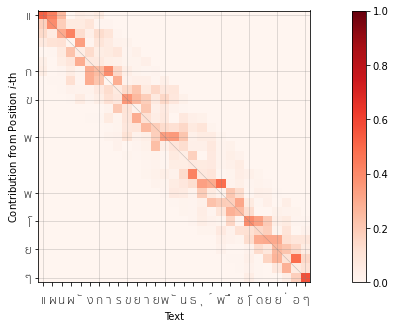

In [239]:
def plot_boundary(boundary):
    for i, b in enumerate(boundary):
        if b:
            plt.axvline(i, color="gray", lw=0.5, alpha=0.5)
            plt.axhline(i, color="gray", lw=0.5, alpha=0.5)

    plt.plot([0, i], [0, i], color="gray", lw=0.5, alpha=0.5)
    
def normalized_relevance(relevances):
    location_relevance = relevances.sum(axis=2)
        
    normalized_location_relevance = np.zeros((relevances.shape[0], relevances.shape[0]))
    
    for i in range(relevances.shape[0]):
        nn = np.abs(location_relevance[:, i])
        nn = nn / np.sum(nn)
        np.testing.assert_almost_equal(np.sum(nn), 1)
        normalized_location_relevance[:, i] = nn 
    return normalized_location_relevance
    

def plot_sc_relevances(sentence, model, wrapper_func, font="Sukhumvit Set", fontsize=12, name=""):
    boundary = word_boundary(model, sentence)

    relevances = interpret_atta_sc(sentence, wrapper_func)
    characters = list(sentence)

    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 1, 1)

    normalized_location_relevance = normalized_relevance(relevances)

    plot_boundary(boundary)
    plt.imshow(normalized_location_relevance, cmap="Reds", vmin=0, vmax=1)
    plt.colorbar()

    plt.ylabel("Contribution from Position $i$-th")

    ix = np.argwhere(boundary).reshape(-1)
    plt.yticks(ix, map(lambda i: characters[i],ix), fontname=font, fontsize=fontsize)
    plt.xticks(range(len(sentence)), list(sentence), fontname=font, fontsize=fontsize)
    plt.xlabel("Text")
    ax.tick_params(axis="x", pad=10, which='major',)
    


plot_sc_relevances(sentences[-1], atta_sc_cnn, lambda: AttaCutSCWrapper(Tokenizer(model=sc_cnn)), name="DilatedCNN(CH+SY)")
plt.savefig("./figures/explained_cnn.png", dpi=300)

In [24]:
# for s in sentences:
#     plot_sc_relevances(s, atta_sc_cnn, lambda: AttaCutSCWrapper(Tokenizer(model=sc_cnn)), name="DilatedCNN(CH+SY)")

In [22]:
class AttaCutLSTMSCWrapper(torch.nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.base = tokenizer

    def forward(self, x):
        embedding = x

        out, _ = self.base.model.lstm(embedding.permute(1, 0, 2))

        out = out.permute(1, 0, 2)

        out = self.base.model.linear1(out)

        return out

using bi-direction


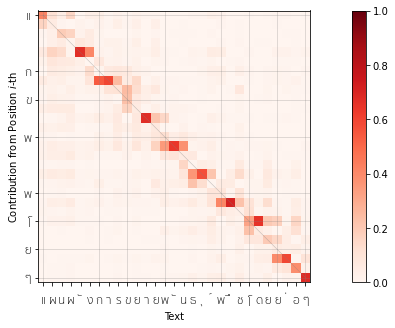

In [240]:
plot_sc_relevances(sentences[-1], atta_sc_lstm, lambda: AttaCutLSTMSCWrapper(Tokenizer(model=sc_lstm)), name="BiLSTM(CH+SY)")
plt.savefig("./figures/explained_lstm.png", dpi=300)

In [25]:
# for s in sentences:
#     plot_sc_relevances(s, atta_sc_lstm, lambda: AttaCutLSTMSCWrapper(Tokenizer(model=sc_lstm)), name="BiLSTM(CH+SY)")

# Compute Stats

In [216]:
with open("../data/best-test/input.txt") as fh:
    best_test = []
    for l in fh:
        l = l.strip()
        if 21 <=len(l) <= 50:
            best_test.append(l)

print(f"we have {len(best_test)}")

we have 338


In [217]:
def merge_dist(score, width=2):
    # score is symmetric metric
    
    dist = np.zeros(width*2+1)
    dist[width] = np.trace(score)
    for i in [-1, 1]:

        for j in range(1, width+1):
            offset = i*j
            dist[width+offset] = np.sum(np.diagonal(score, offset=offset))

        
    return dist


merge_dist(
    np.array(
        [
            [0.5, 0.3, 0.1, 0.0, 0.0, 0.0, 0.2],
            [0.1, 0.3, 0.3, 0.1, 0.0, 0.0, 0.0],
            [0.1, 0.3, 0.8, 0.1, 0.1, 0.0, 0.0],
            [0.0, 0.3, 0.2, 0.3, 0.5, 0.1, 0.0],
            [0.0, 0.3, 0.2, 0.3, 0.5, 0.1, 0.0],
            [0.0, 0.1, 0.2, 0.3, 0.3, 0.5, 0.0],
            [0.0, 0.0, 0.2, 0.3, 0.1, 0.3, 0.8],
        ]
    ).T
)

array([0.4, 1.3, 3.7, 1.5, 1. ])

In [230]:
def compute_dist(data, wrapper_func):
    width = 10
    dist = np.zeros(2*width+1)
    for i, sentence in enumerate(data):

        relevances = interpret_atta_sc(sentence, wrapper_func)

        relevances = np.abs(np.sum(relevances, axis=2))

        dist += merge_dist(relevances, width=width)
        if (i + 1) % 5 == 0:
            print("finished ", i)
    return dist
            
dist = compute_dist(best_test, lambda: AttaCutSCWrapper(Tokenizer(model=sc_cnn)))

finished  4
finished  9
finished  14
finished  19
finished  24
finished  29
finished  34
finished  39
finished  44
finished  49
finished  54
finished  59
finished  64
finished  69
finished  74
finished  79
finished  84
finished  89
finished  94
finished  99
finished  104
finished  109
finished  114
finished  119
finished  124
finished  129
finished  134
finished  139
finished  144
finished  149
finished  154
finished  159
finished  164
finished  169
finished  174
finished  179
finished  184
finished  189
finished  194
finished  199
finished  204
finished  209
finished  214
finished  219
finished  224
finished  229
finished  234
finished  239
finished  244
finished  249
finished  254
finished  259
finished  264
finished  269
finished  274
finished  279
finished  284
finished  289
finished  294
finished  299
finished  304
finished  309
finished  314
finished  319
finished  324
finished  329
finished  334


In [234]:
dist

array([   0.        ,    0.        ,    0.        ,    0.        ,
         59.61781027,   90.30578896,  117.12053522,   79.49536354,
        304.73355024,  716.09948972, 1302.7253283 ,  582.86125981,
        240.56796141,  102.57051674,  123.84798166,   83.16355937,
         58.02988137,    0.        ,    0.        ,    0.        ,
          0.        ])

In [241]:
dist_lstm = compute_dist(best_test, lambda: AttaCutLSTMSCWrapper(Tokenizer(model=sc_lstm)))

using bi-direction
using bi-direction
using bi-direction
using bi-direction
using bi-direction
finished  4
using bi-direction
using bi-direction
using bi-direction
using bi-direction
using bi-direction
finished  9
using bi-direction
using bi-direction
using bi-direction
using bi-direction
using bi-direction
finished  14
using bi-direction
using bi-direction
using bi-direction
using bi-direction
using bi-direction
finished  19
using bi-direction
using bi-direction
using bi-direction
using bi-direction
using bi-direction
finished  24
using bi-direction
using bi-direction
using bi-direction
using bi-direction
using bi-direction
finished  29
using bi-direction
using bi-direction
using bi-direction
using bi-direction
using bi-direction
finished  34
using bi-direction
using bi-direction
using bi-direction
using bi-direction
using bi-direction
finished  39
using bi-direction
using bi-direction
using bi-direction
using bi-direction
using bi-direction
finished  44
using bi-direction
using bi-di

In [246]:
dist_lstm_5 = compute_dist(best_test[:5], lambda: AttaCutLSTMSCWrapper(Tokenizer(model=sc_lstm)))

using bi-direction


/Users/pat/projects/attacut/venv/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0543880159114884 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/Users/pat/projects/attacut/venv/lib/python3.7/site-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "


using bi-direction
using bi-direction
using bi-direction
using bi-direction
finished  4


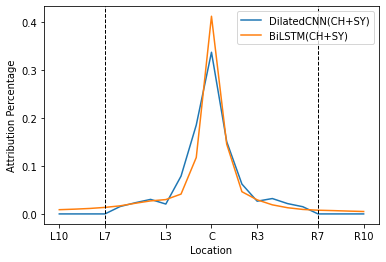

In [252]:
conf_filter_width = 7 
plt.plot(dist/np.sum(dist), label="DilatedCNN(CH+SY)")
plt.plot(dist_lstm/np.sum(dist_lstm), label="BiLSTM(CH+SY)")
plt.xticks([0, 10-conf_filter_width, 10-3, 10, 10+3, 10+conf_filter_width, 20], ["L10", "L7", "L3", "C", "R3", "R7", "R10"]);
plt.axvline(10-conf_filter_width, lw=1, ls="--", color="black")
plt.axvline(10+conf_filter_width, lw=1, ls="--", color="black")
plt.legend();
plt.ylabel("Attribution Percentage")
plt.xlabel("Location")
plt.savefig("./figures/attribution-dist.png", dpi=300)